# Editing a scene

## Overview

In this tutorial, you will learn how to modify a Mitsuba scene after it has been loaded from a file. You might want to edit a scene before (re-)rendering it for many reasons. Maybe a corner is dim, or an object should be moved a bit to the left. Thankfully we can use the *traverse* mechanism to perform such modifications in Python with Mitsuba 3. As we will see in later tutorials, this mechanism is also essential for inverse rendering applications and more.

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**

<ul>
  <li>List exposed parameters of Mitsuba objects</li>
  <li>Edit a scene and update its internal state accordingly</li>
</ul>

</div>

## Loading a scene

Following the same steps as in [Mitsuba quickstart tutorial][1], let's import `mitsuba`, set the desired variant and load a scene from an XML file on disk.

[1]: https://mitsuba.readthedocs.io/en/latest/src/quickstart/mitsuba_quickstart.html

In [1]:
import drjit as dr
import mitsuba as mi
mi.set_variant('llvm_ad_rgb')

scene = mi.load_file('../scenes/simple.xml')

Let's quickly render this scene.

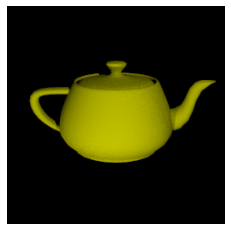

In [2]:
original_image = mi.render(scene, spp=128)

import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(original_image ** (1.0 / 2.2))

## Accessing scene parameters

Any Mitsuba object can be inspected using the [<code>traverse()</code>][1] function, which returns a instance of [<code>SceneParameters</code>][2]. It has a similar API to Python `dict` and holds all parameters that are exposed by the input object and its children. Therefore, when given a scene as input, this function will return the parameters of all the objects present in the scene.

Let's print the paramters available in our teapot scene.

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.traverse
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.SceneParameters

In [3]:
params = mi.traverse(scene)
print(params)

SceneParameters[
  ----------------------------------------------------------------------------------------
  Name                                 Flags    Type            Parent
  ----------------------------------------------------------------------------------------
  sensor.near_clip                              float           PerspectiveCamera
  sensor.far_clip                               float           PerspectiveCamera
  sensor.shutter_open                           float           PerspectiveCamera
  sensor.shutter_open_time                      float           PerspectiveCamera
  sensor.x_fov                                  float           PerspectiveCamera
  sensor.to_world                               Transform4f     PerspectiveCamera
  teapot.bsdf.reflectance.value        ∂        Color3f         SRGBReflectanceSpectrum
  teapot.vertex_count                           int             PLYMesh
  teapot.face_count                             int             PLYMesh
  teap

As you can see, the first level of our scene graph has 4 objects: 

- the camera (`sensor`)
- the teapot mesh (`teapot`)
- two light sources (`light1` and `light2`). 

Some of those objects have nested child objects, like `teapot.bsdf`.

Names like *teapot* are defined in the `id` field in the XML file. Parameters such as `teapot.vertex_positions` or `sensor.far_clip` are documented in their respective parent's plugin documentation (see [PLYMesh][1] and [PerspectiveCamera][2]). The plugin documentation lists which parameters are exposed, as well as all input parameters it takes in the XML file.

If you wish to modifiy a plugin's parameter that is not exposed with `traverse`, you still have the option to modify the XML file directly. `traverse` is merely a convenience function to edit scene objects in-place.

Individual scene parameters can be accessed with the `__getitem__` operator, providing the `key` corresponding to the parameter. Let's print some scene parameter values.

[1]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_shapes.html#ply-stanford-triangle-format-mesh-loader-ply
[2]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_sensors.html#perspective-pinhole-camera-perspective

In [4]:
print('sensor.near_clip:             ',  params['sensor.near_clip'])
print('teapot.bsdf.reflectance.value:',  params['teapot.bsdf.reflectance.value'])
print('light1.intensity.value:       ',  params['light1.intensity.value'])

sensor.near_clip:              0.009999999776482582
teapot.bsdf.reflectance.value: [[0.8999999761581421, 0.8999999761581421, 0.0]]
light1.intensity.value:        [[100.0, 100.0, 100.0]]


## Edit the scene

Similarly to a Python `dict`, parameters can be modified in-place using the `__setitem__` operator. However, it is necessary to call the `SceneParameters.update` method to properly apply the desired changes.

Some objects need to be notified if the children have been updated. For instance, a change to the vertex position buffer of a mesh will trigger the recomputation of the Embree/Optix BHV.

Internally, the `SceneParameters` object will record every update written to it.
Using `SceneParameters.update` will propagate all updates through the dependency graph, and perform all necessary updates to the parent objects.

In [5]:
# Give a red tint to light1 and a green tint to light2
params['light1.intensity.value'] *= [1.5, 0.2, 0.2]
params['light2.intensity.value'] *= [0.2, 1.5, 0.2]

# Apply updates
params.update()

Mesh editing is also possible but requires specifying the layout of the stored data. See [transformation toolbox][1] and [mesh manipulation][2] for more geometry and mesh operations.

[1]: https://mitsuba.readthedocs.io/en/latest/src/how_to_guides/mesh_io_and_manipulation.html
[2]: https://mitsuba.readthedocs.io/en/latest/src/how_to_guides/image_io_and_manipulation.html

In [6]:
# Translate the teapot a little bit
V = dr.unravel(mi.Point3f, params['teapot.vertex_positions'])
V.z += 0.5
params['teapot.vertex_positions'] = dr.ravel(V)

# Apply changes
params.update()

After rendering the scene again, we can easily compare the rendered images using `matplotlib`. 

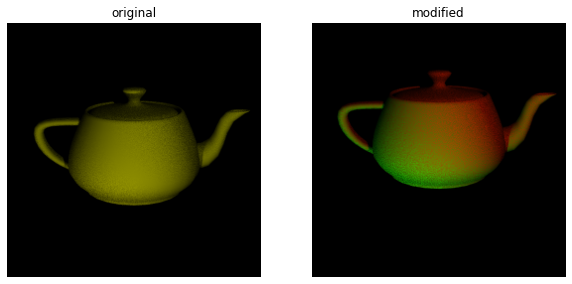

In [7]:
modified_image = mi.render(scene, spp=128)
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1,2,1).imshow(original_image); plt.axis('off'); plt.title('original')
fig.add_subplot(1,2,2).imshow(modified_image); plt.axis('off'); plt.title('modified')

## See also

- [<code>mitsuba.traverse()</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.traverse)
- [<code>mitsuba.SceneParameters</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html##mitsuba.SceneParameters)